# Experiment with exporting a text layer to PDF

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import subprocess
import os
import tempfile

import pymupdf
from pymupdf import TextWriter
import cv2
import matplotlib.pyplot as plt
from htr_pipeline import read_page, DetectorConfig, LineClusteringConfig
from tqdm import tqdm

from xournalpp_htr.utils import export_to_pdf_with_xournalpp
from xournalpp_htr.documents import XournalDocument

/home/martin/anaconda3/envs/xournalpp_htr/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(
/home/martin/anaconda3/envs/xournalpp_htr/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


## Goal

Export as PDF: Write a script that uses XOJ as input and exports a PDF with text layer.

## Settings

In [3]:
XOJ_PATH = Path('../tests/test_1.xoj')
PDF_PATH = XOJ_PATH.with_suffix('.pdf')
PDF_PATH_OCR = PDF_PATH.parent / Path(PDF_PATH.stem+'_ocrd').with_suffix('.pdf')

## Step 1: XOJ to PDF

First, turn test file from `xoj` into `pdf`.

In [4]:
export_to_pdf_with_xournalpp(XOJ_PATH, PDF_PATH)


PosixPath('../tests/test_1.pdf')

## Step 2: Perform HTR predictions

In [42]:
DEBUG_HTR = False # e.g. allows storage of intermediate data
PREDICTION_IMAGE_DIR = None
PREDICTION_IMAGE_DIR = Path('TEST_IMG') # Store prediction images in there for debugging purposes

In [44]:
predictions = {}

input_file = XOJ_PATH

file_ending = input_file.suffix

if file_ending == '.xoj':
    document = XournalDocument(input_file)
else:
    raise NotImplementedError(f'File ending "{file_ending}" currently not readable.')

nr_pages = len( document.pages )

for page_index in tqdm(range(nr_pages)):

    with tempfile.NamedTemporaryFile(dir='/tmp', delete=False, prefix=f'xournalpp_htr__page{page_index}__', suffix='.jpg') as tmpfile:
        TMP_FILE = Path(tmpfile.name)
    
        written_file = document.save_page_as_image(page_index, TMP_FILE, False, dpi=150)

        # ======
        # Do HTR
        # ======

        # read image
        img = cv2.imread(str(written_file), cv2.IMREAD_GRAYSCALE)

        # detect and read text
        #height = 700 # good
        #enlarge = 5
        #enlarge = 10
        # height = 1000 # good
        # height = 1600 # not good
        scale = 0.4
        margin = 5
        read_lines = read_page(img, 
                               DetectorConfig(scale=scale, margin=margin), 
                               line_clustering_config=LineClusteringConfig(min_words_per_line=2))
        
        predictions_page = []
        for line in read_lines:
            for word in line:
                data = {
                    'page_index': page_index,
                    'text': word.text,
                    'xmin': word.aabb.xmin,
                    'xmax': word.aabb.xmax,
                    'ymin': word.aabb.ymin,
                    'ymax': word.aabb.ymax,
                }
                predictions_page.append(data)
        predictions[page_index] = predictions_page

/home/martin/anaconda3/envs/xournalpp_htr/lib/python3.10/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(
100%|██████████| 4/4 [00:09<00:00,  2.26s/it]


Plot the predictions to ensure that they are working correctly:

In [68]:
if PREDICTION_IMAGE_DIR:

    PREDICTION_IMAGE_DIR.mkdir(parents=True, exist_ok=True)

    nr_pages = len( document.pages )

    for page_index in tqdm(range(nr_pages)):

        file_name = PREDICTION_IMAGE_DIR / f'page{page_index}.jpg'
        file_name_ocrd = PREDICTION_IMAGE_DIR / f'page{page_index}_ocrd.jpg'

        written_file = document.save_page_as_image(page_index, file_name, False, dpi=150)

        # ======
        # Do HTR
        # ======

        # read image
        img = cv2.imread(str(written_file), cv2.IMREAD_GRAYSCALE)
    
        # To prepare plotting
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        # Impose predictions on image
        for prediction in predictions[page_index]:

            text = prediction['text']
            xmin = prediction['xmin']
            xmax = prediction['xmax']
            ymin = prediction['ymin']
            ymax = prediction['ymax']

            img = cv2.rectangle(img,
                                (int(xmin), int(ymax)),
                                (int(xmax), int(ymin)),
                                (255, 0, 0),
                                2)
            
            img = cv2.putText(img,
                            text=text,
                            org=(int(xmin), int(ymin)),
                            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                            fontScale=1,
                            color=(255, 0, 0),
                            thickness=1,
                            )
                
        plt_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        figure_aspect_ratio = float(document.pages[page_index].meta_data['height']) / float(document.pages[page_index].meta_data['width'])
        plt.figure(figsize=(10, 10*figure_aspect_ratio))
        imgplot = plt.imshow(plt_image)
        plt.savefig(file_name_ocrd, dpi=150)
        plt.close()

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


## Step 3: Store predictions in PDF

In [86]:
try:
    os.remove(PDF_PATH_OCR)
except Exception as e:
    print(f'Error encountered while deleting {PDF_PATH_OCR}', e)

doc = pymupdf.open(PDF_PATH)

input_file = XOJ_PATH

nr_pages = len( document.pages )
nr_pages = 1 # DEBUGGING MODE!

for page_index in tqdm(range(nr_pages)):

    pdf_page = doc[page_index]

    tw = TextWriter(pdf_page.rect)

    # Store text
    for prediction in predictions[page_index][6:7]: # DEBUGGING MODE!

        pass

        print(prediction)

        tw.append(
            (5, 8),
            # (1.0*i_read_line, 0.0),
            prediction['text'],
            font=None,
            fontsize=11,
        )
            
    tw.write_text(pdf_page, render_mode=1) # render_mode=3 == hidden text
    # TODO: How to adjust text to a given bounding box as to perfectly align
    #       with text recognition?
    #       See here: https://pymupdf.readthedocs.io/en/latest/recipes-text.html

doc.ez_save(PDF_PATH_OCR)

100%|██████████| 1/1 [00:00<00:00, 220.16it/s]

{'page_index': 0, 'text': 'DATA', 'xmin': 678, 'xmax': 747, 'ymin': 136, 'ymax': 175}


[{'page_index': 0,
  'text': 'DATA',
  'xmin': 678,
  'xmax': 747,
  'ymin': 136,
  'ymax': 175}]

Next, using some dummy text and position, try to add hidden (=searchable) text to PDF. Based on [this issue](https://github.com/pymupdf/PyMuPDF/discussions/775#discussioncomment-219578) found using G"python add hidden text to pdf".

In [5]:
try:
    os.remove(PDF_PATH_OCR)
except Exception as e:
    print(f'Error encountered while deleting {PDF_PATH_OCR}', e)

doc = pymupdf.open(PDF_PATH)

for page in doc:

    text = 'a wee test!'

    tw = TextWriter(page.rect)
    tw.append(
        (0.0, 0.0),
        text,
        font=None,
        fontsize=11,
    )
    tw.write_text(page, render_mode=3) # render_mode=3 == hidden text
    # TODO: How to adjust text to a given bounding box as to perfectly align
    #       with text recognition?

doc.ez_save(PDF_PATH_OCR)

Next, apply HTR and save the text correspondingly.

/home/martin/anaconda3/envs/xournalpp_htr/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(
/home/martin/anaconda3/envs/xournalpp_htr/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


In [9]:
doc.pages(1)

<generator object Document.pages at 0x735e88313300>

/home/martin/anaconda3/envs/xournalpp_htr/lib/python3.10/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(
  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/xournalpp_htr__page0__49vin28t.jpg
/tmp/xournalpp_htr__page0__49vin28t_ocrd.jpg


100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


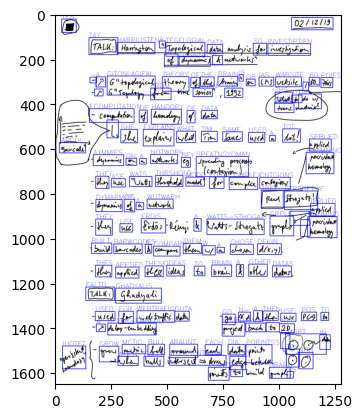

In [12]:
try:
    os.remove(PDF_PATH_OCR)
except Exception as e:
    print(f'Error encountered while deleting {PDF_PATH_OCR}', e)

doc = pymupdf.open(PDF_PATH)

input_file = XOJ_PATH

# TMP_FILE = Path.home() / Path('xournalpp_htr_tmp_image.jpg')

file_ending = input_file.suffix

if file_ending == '.xoj':
    document = XournalDocument(input_file)
else:
    raise NotImplementedError(f'File ending "{file_ending}" currently not readable.')

nr_pages = len( document.pages )
nr_pages = 1

for page_index in tqdm(range(nr_pages)):

    pdf_page = doc[page_index]

    with tempfile.NamedTemporaryFile(dir='/tmp', delete=False, prefix=f'xournalpp_htr__page{page_index}__', suffix='.jpg') as tmpfile:
        TMP_FILE = Path(tmpfile.name)
        TMP_FILE_OCR = TMP_FILE.parent / Path(TMP_FILE.stem+'_ocrd').with_suffix('.jpg')

        print(TMP_FILE)
        print(TMP_FILE_OCR)
    
        written_file = document.save_page_as_image(page_index, TMP_FILE, False, dpi=150)

        # ======
        # Do HTR
        # ======

        # read image
        img = cv2.imread(str(written_file), cv2.IMREAD_GRAYSCALE)

        # detect and read text
        #height = 700 # good
        #enlarge = 5
        #enlarge = 10
        # height = 1000 # good
        # height = 1600 # not good
        scale = 0.4
        margin = 5
        read_lines = read_page(img, 
                                DetectorConfig(scale=scale, margin=margin), 
                                line_clustering_config=LineClusteringConfig(min_words_per_line=2))
    
        # To prepare plotting
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        tw = TextWriter(pdf_page.rect)
    
        # output text
        for i_read_line, read_line in enumerate(read_lines):
            recognitions = ' '.join(read_word.text for read_word in read_line)
            # print(f'- "{recognitions}"')
            for read_word in read_line:

                box_int = read_word.aabb.enlarge_to_int_grid()

                img = cv2.rectangle(img,
                                    (int(box_int.xmin), int(box_int.ymax)),
                                    (int(box_int.xmax), int(box_int.ymin)),
                                    (255, 0, 0),
                                    2)
                
                img = cv2.putText(img,
                                text=read_word.text,
                                org=(int(box_int.xmin), int(box_int.ymin)),
                                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                                fontScale=1,
                                color=(255, 0, 0),
                                thickness=1,
                                )
                
                tw.append(
                    (box_int.xmin, box_int.ymin),
                    # (1.0*i_read_line, 0.0),
                    read_word.text,
                    font=None,
                    fontsize=11,
                )
                
        tw.write_text(pdf_page, render_mode=1) # render_mode=3 == hidden text
        # TODO: How to adjust text to a given bounding box as to perfectly align
        #       with text recognition?
        #       See here: https://pymupdf.readthedocs.io/en/latest/recipes-text.html

        plt_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgplot = plt.imshow(plt_image)
        plt.savefig(TMP_FILE_OCR)

doc.ez_save(PDF_PATH_OCR)

In [5]:
# TODO: I want to build prediction code that can run both in a CLI and in a notebook like this here. Also, I'd like to be able to set the model flexibly.